# Class 10

###### 1. Data import and Data preparation
###### 2. Compute the Equilibrium Expected returns and Covariance matrix
###### 3. Compute the Prior distribution - Views
###### 4. Construction of the Posterior distribution
###### 5. Portfolio optimization
###### 6. Global Minimum Variance portfolio
###### 7. Risk Parity portfolio

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf     # To install it: "pip install yfinance --upgrade --no-cache-dir"
from datetime import date
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import cm
from pylab import rcParams 

##### 1. Data import and Data preparation

In [2]:
# Settings for data download

start_date = "2019-01-01"     # Start date for the download 
end_date = date.today().strftime("%Y-%m-%d")
assetList =["AAPL","AMZN","GOOGL", "TSLA", "NVDA","JPM"] 
n = len(assetList)

data_ = yf.download(assetList, start=start_date, end=end_date)#
data = data_["Close"]  

[*********************100%***********************]  6 of 6 completed


In [3]:
# Create the returns dataframe
ret = (data-data.shift(1))/data.shift(1) # Create returns dataframe

In [4]:
ret.head()

Ticker,AAPL,AMZN,GOOGL,JPM,NVDA,TSLA
Date,,,,,,
2019-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03 00:00:00+00:00,-0.099607,-0.025241,-0.027696,-0.022153,-0.060417,-0.031472
2019-01-04 00:00:00+00:00,0.042689,0.050064,0.051294,0.036865,0.064068,0.057697
2019-01-07 00:00:00+00:00,-0.002226,0.034353,-0.001994,0.000695,0.052941,0.054361
2019-01-08 00:00:00+00:00,0.019063,0.016612,0.008783,-0.001886,-0.024895,0.001164


##### 2. Compute the Equilibrium Expected returns and Covariance matrix

In [5]:
# Compute (annualized) sample mean and sample covariance

muBarData = ret.mean()*252
SigmaBarData = ret.cov()*252 

# Convert from Pandas DataFrame to Numpy arrays using to_numpy()
muBar = muBarData.to_numpy()
# Define muBar as a column vector
muBar.shape = (n,1)     

SigmaBar = SigmaBarData.to_numpy()

In [6]:
# Define constants for units of measurement
T = 10**12  # Trillions (1 trillion = 1,000 billion)
B = 10**9   # Billions

# Updated market capitalizations (in trillions and billions)
# These values are based on the most recent market data
mktCap = np.array([
    3.441 * T,    # Apple (AAPL)
    2.197 * T,    # Amazon (AMZN)
    2.201 * T,    # Alphabet (GOOGL)
    1.038 * T,    # Tesla (TSLA)
    3.631 * T,    # NVIDIA (NVDA)
    711.156 * B   # JPMorgan Chase (JPM)
])

# Calculate the market weights for each asset
# Market weight = Individual market cap / Total market cap
mktW = mktCap / np.sum(mktCap)

# Print the market weights as percentages
print("The updated market weights are:")
for asset, weight in zip(assetList, mktW):
    print(f"{asset}: {weight:.2%}")

The updated market weights are:
AAPL: 26.03%
AMZN: 16.62%
GOOGL: 16.65%
TSLA: 7.85%
NVDA: 27.47%
JPM: 5.38%


In [7]:
# Calculate the expected return of the market portfolio
# The market portfolio expected return is a weighted average of the asset returns
# mktMu = mktW.T @ muBar  # .T is used for transpose

# or

# Fix the expected return of the market portoflio as 5% + the risk free rate. Assume that the risk free is 3%

mktMu = 0.08
print("Expected return of the market portfolio (mktMu):", mktMu)

# Calculate the variance of the market portfolio
# The market portfolio variance is computed using the formula: w' * Sigma * w
mktSigma = mktW.T @ SigmaBar @ mktW
print("Variance of the market portfolio:", mktSigma)

# Estimate the coefficient of risk aversion (lambda) --> lam = mu_{mkt}/var_{mkt}
# Lambda (lam) is defined as the ratio of the expected return to the variance of the market portfolio
lam = mktMu / mktSigma
print("Estimated coefficient of risk aversion (lambda):", lam)

Expected return of the market portfolio (mktMu): 0.08
Variance of the market portfolio: 0.09673562046801176
Estimated coefficient of risk aversion (lambda): 0.8269962978782377


In [8]:
# Calculate the equilibrium expected returns (Pi)
# Pi = lambda * SigmaBar * mktW
# This is based on the Capital Asset Pricing Model (CAPM) equilibrium

# Compute the equilibrium expected returns vector
Pi = lam * SigmaBar @ mktW

# Reshape the result to be a column vector (n, 1)
Pi = Pi.reshape(-1, 1)

# Print the equilibrium expected returns
print("Equilibrium Expected Return (Pi):")
print(Pi)

Equilibrium Expected Return (Pi):
[[0.06585525]
 [0.06793803]
 [0.06316401]
 [0.0381179 ]
 [0.11901496]
 [0.09974049]]


##### 3. Compute the Prior distribution - Views

In [9]:
# Define investor views (Q)
# We now have two views:
# 1. We expect TSLA (Tesla) to have an expected return of 45% next year.
# 2. We believe that GOOGL (Alphabet) will outperform JPM (JPMorgan Chase) by 5%.

Q = np.array([0.45, 0.05]).reshape(-1, 1)  # Reshape Q to be a column vector
print("Views (Q):")
print(Q)

# Define the pick matrix (P)
# The P matrix selects which assets the views apply to, based on the order in assetList:
# 1. The first view is an absolute view on TSLA (Tesla), so we place 1 for TSLA and 0 elsewhere.
# 2. The second view is a relative view: GOOGL (Alphabet) will outperform JPM (JPMorgan Chase),
#    so we place 1 for GOOGL and -1 for JPM, with 0 elsewhere.

P = np.array([
    [0, 0, 0, 1, 0, 0],  # Absolute view on TSLA
    [0, 0, 1, 0, 0, -1]  # Relative view: GOOGL vs JPM
])
print("Pick matrix (P):")
print(P)

# Define the Uncertainty matrix (Omega)
# Omega is a diagonal matrix that represents the uncertainty (variance) of each view.
# IMPORTANT: Omega values indicate the level of uncertainty, not directly the confidence.
# - A low value in Omega means we are confident in the view (low uncertainty).
# - A high value in Omega means we are less confident in the view (high uncertainty).
#
# Here, we set:
# - 0.05 for the first view (high confidence, low uncertainty on TSLA's expected return).
# - 0.15 for the second view (lower confidence, higher uncertainty on the relative performance of GOOGL vs JPM).

Omega = np.diag([0.05, 0.15])
print("Confidence matrix (Omega):")
print(Omega)

# Explanation of Omega:
# Increasing the values in Omega means increasing the uncertainty of the views, which results in:
# - The posterior distribution being more influenced by the (market equilibrium).
# - The views having less impact on the posterior expected returns.
#
# Conversely, decreasing the values in Omega means decreasing the uncertainty of the views, which results in:
# - The posterior distribution being more influenced by the views (Q).
# - The views having a stronger impact on the posterior expected returns.


Views (Q):
[[0.45]
 [0.05]]
Pick matrix (P):
[[ 0  0  0  1  0  0]
 [ 0  0  1  0  0 -1]]
Confidence matrix (Omega):
[[0.05 0.  ]
 [0.   0.15]]


##### 4. Construction of the Posterior distribution

In [11]:
# Define the parameter tau
# Tau represents the uncertainty in the prior (market equilibrium returns).
# A common choice is tau = 1 / T, where T is the number of observations (e.g., T = 252 for daily returns in a year).
# The value of tau influences how much we weight the market equilibrium vs. the investor views.
# T = 360  # Number of observations (e.g., 360 trading days)
# tau = 1 / T
tau = 0.1 # Empirical Tau
print("Value of tau:", tau)

# Compute the inverse of SigmaBar (prior covariance matrix) and Omega (confidence matrix)
SigmaBarInv = np.linalg.inv(SigmaBar)
OmegaInv = np.linalg.inv(Omega)

# Transpose of the pick matrix P
Pt = P.T

# Calculate the posterior covariance matrix (M)
# SigmaBarPost = (1/tau * SigmaBarInv + P' * OmegaInv * P)^(-1)
# The value of tau affects this calculation:
# - A small tau gives more weight to the prior covariance (SigmaBar), reducing the influence of the investor views.
# - A large tau gives more weight to the investor views, increasing their impact on the posterior estimates.
SigmaBarPost = np.linalg.inv((1 / tau) * SigmaBarInv + Pt @ OmegaInv @ P)

# Calculate the posterior mean (muBarPost)
# muBarPost = SigmaBarPost * ((1/tau * SigmaBarInv * Pi) + (P' * OmegaInv * Q))
# Here, the influence of tau is seen in how the prior mean (Pi) and investor views (Q) are combined:
# - A small tau increases the weight of the prior mean (Pi), making the posterior mean closer to the market equilibrium.
# - A large tau increases the weight of the views (Q), making the posterior mean reflect the investor's opinions more strongly.
muBarPost = SigmaBarPost @ ((1 / tau) * SigmaBarInv @ Pi + Pt @ OmegaInv @ Q)


# Print the posterior mean and compare with the prior mean (Pi)
print("Posterior Mean (muBarPost) vs Prior Mean (Pi):")
print(np.concatenate((muBarPost, Pi), axis=1))


Value of tau: 0.1
Posterior Mean (muBarPost) vs Prior Mean (Pi):
[[0.09107305 0.06585525]
 [0.08676157 0.06793803]
 [0.0907919  0.06316401]
 [0.10251757 0.0381179 ]
 [0.15301666 0.11901496]
 [0.11901312 0.09974049]]


In [13]:
# Function to compute portfolio expected return
def ptfRet(x, mu):
    # Portfolio return = x' * muBar
    return x.T @ mu

# Function to compute portfolio variance
def ptfVar(x, Variance):
    # Portfolio variance = x' * SigmaBar * x
    return (x.T @ Variance) @ x

# Function to plot portfolio weights
def plot_weights(w1, w2, leg1, leg2, title):
    # x-axis represents asset indices
    x = np.arange(len(assetList)) + 1

    # Extract the portfolio weights
    heights1 = np.squeeze(w1)
    heights2 = np.squeeze(w2)

    # Create a bar plot
    plt.figure(figsize=(10, 4))

    # Plot 
    plt.bar(x, heights1, width=0.2, label=leg1)

    # Plot Black-Litterman weights
    plt.bar(x + 0.2, heights2, width=0.2, label=leg2)

    # Customize the plot
    plt.xticks(x + 0.2, assetList)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()



#### 5. Optimal portfolio

In [14]:
# Find the optimal mean-variance portfolio using the traditional Markowitz model

mu0 = 0.3                            # Target portfolio expected return

linConstraint = ({'type': 'eq', 'fun': lambda x: ptfRet(x,muBar) - mu0}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

w0 = n*[1./n]        # Choose as starting portfolio the equally weighted portfolio 
res = minimize(ptfVar, w0, args=(SigmaBar), method='SLSQP', constraints=linConstraint, options={'ftol': 1e-09})
wBarM = res.x
wBarM.shape = (n,1)

ptf_1a_ER = ptfRet(res.x, muBar)[0][0]
print("Portfolio expected return is:", ptf_1a_ER)
ptf_1a_EV = np.sqrt(ptfVar(res.x, SigmaBar))[0][0]
print("Portfolio volatility is:", ptf_1a_EV)
ptf_1a_SR = ptf_1a_ER/ptf_1a_EV
print("Portfolio Sharpe ratio is:", ptf_1a_SR)

Portfolio expected return is: 0.2999999999997839
Portfolio volatility is: 0.2522998286531081
Portfolio Sharpe ratio is: 1.1890614496304697


In [15]:
# Find the optimal mean-variance portfolio using the Black Litterman model

mu0 = 0.3                              

linConstraintBl = ({'type': 'eq', 'fun': lambda x: ptfRet(x,muBarPost) - mu0}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

w0 = n*[1./n]        # Choose as starting portfolio the equally weighted portfolio 
res = minimize(ptfVar, w0, args=(SigmaBar), method='SLSQP', constraints=linConstraintBl, options={'ftol': 1e-09})
wBarBl = res.x
wBarBl.shape = (n,1)

ptf_1b_ER = ptfRet(res.x, muBarPost)[0][0]
print("Portfolio expected return is:", ptf_1b_ER)
ptf_1b_EV = np.sqrt(ptfVar(res.x, SigmaBar))[0][0]
print("Portfolio volatility is:", ptf_1b_EV)
ptf_1b_SR = ptf_1b_ER/ptf_1b_EV
print("Portfolio Sharpe ratio is:", ptf_1b_SR)

Portfolio expected return is: 0.3000000000003275
Portfolio volatility is: 1.272927885170941
Portfolio Sharpe ratio is: 0.23567713732662918


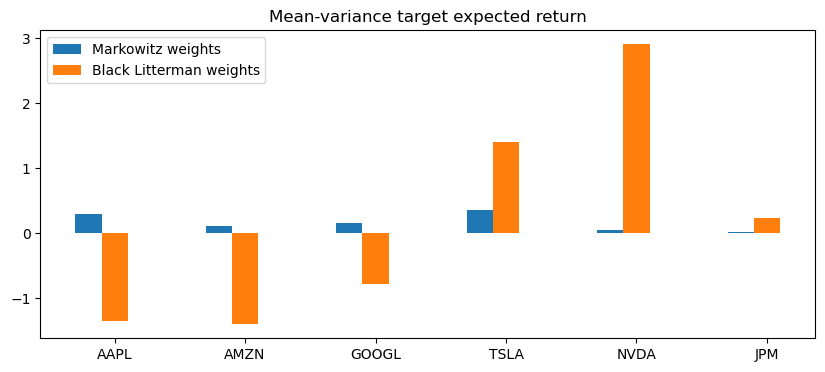

In [16]:
# Plot bar diagram with weights - target expected return
plot_weights(wBarM,wBarBl,'Markowitz weights','Black Litterman weights', 'Mean-variance target expected return')

##### 6. Global Minimum variance Portfolio

In [17]:
# Find the global minimum variance portfolio using the Markowitz model

linConstraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

w0 = n*[1./n]        # Choose as starting portfolio the equally weighted portfolio 
res = minimize(ptfVar, w0, args=(SigmaBar), method='SLSQP', constraints=linConstraint, options={'ftol': 1e-09})
wBarM = res.x
wBarM.shape = (n,1)

ptf_2a_ER = ptfRet(res.x, muBar)[0][0]
print("Portfolio expected return is:", ptf_2a_ER)
ptf_2a_EV = np.sqrt(ptfVar(res.x, SigmaBar))[0][0]
print("Portfolio volatility is:", ptf_2a_EV)
ptf_2a_SR = ptf_2a_ER/ptf_2a_EV
print("Portfolio Sharpe ratio is:", ptf_2a_SR)

Portfolio expected return is: 0.18469156766708572
Portfolio volatility is: 0.23808721356569706
Portfolio Sharpe ratio is: 0.7757307286731822


In [18]:
# Find the global minimum variance portfolio using the Black Litterman model

linConstraintBl = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

w0 = n*[1./n]        # Choose as starting portfolio the equally weighted portfolio 
res = minimize(ptfVar, w0, args=(SigmaBar), method='SLSQP', constraints=linConstraintBl, options={'ftol': 1e-09})
wBarBl = res.x
wBarBl.shape = (n,1)

ptf_2b_ER = ptfRet(res.x, muBarPost)[0][0]
print("Portfolio expected return is:", ptf_2b_ER)
ptf_2b_EV = np.sqrt(ptfVar(res.x, SigmaBarPost))[0][0]
print("Portfolio volatility is:", ptf_2b_EV)
ptf_2b_SR = ptf_2b_ER/ptf_2b_EV
print("Portfolio Sharpe ratio is:", ptf_2b_SR)

Portfolio expected return is: 0.08627058254539298
Portfolio volatility is: 0.0716056694825921
Portfolio Sharpe ratio is: 1.2048010048473332


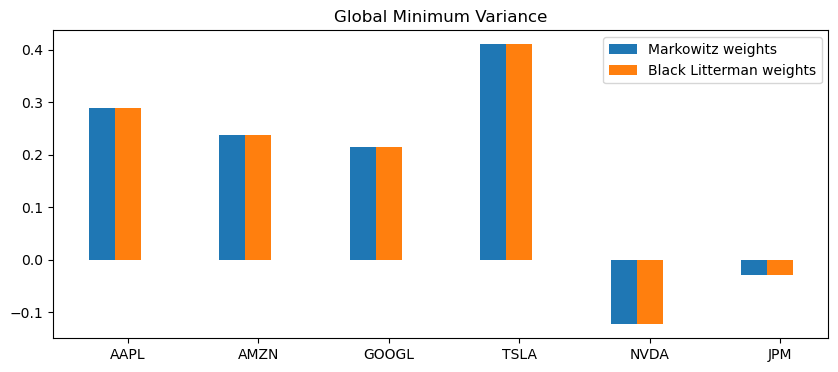

In [19]:
# Plot bar diagram with weights - global minimum variance

# The weights and volatility of the Global Minimum Variance (GMV) portfolio are identical for both Markowitz and Black-Litterman approaches.
# This is because the GMV portfolio is calculated based on the covariance matrix (SigmaBar), which is the same in both cases.
# However, the expected return differs because Markowitz uses the equilibrium returns (muBar), while Black-Litterman uses the posterior returns (muBarPost).


plot_weights(wBarM,wBarBl,'Markowitz weights','Black Litterman weights', 'Global Minimum Variance')

##### 7. Risk Parity portfolio

In [20]:
# Objective function for Risk Parity
# The goal is to find portfolio weights such that the risk contribution of each asset is the same.
# In Risk Parity, we set: w_1 * MR_1 = w_2 * MR_2 = w_3 * MR_3 = ... = w_n * MR_n
# where:
# - w_i is the weight of asset i.
# - MR_i is the marginal risk contribution of asset i.
# This means that each asset contributes equally to the total portfolio risk.

def ptfRP(x, SigmaBar, target_vol, n):
    MR = (SigmaBar @ x) /  np.sqrt(x.T @ SigmaBar@ x)  # Marginal risk contribution of each asset
    target = target_vol/n           # Target risk contribution (equal for all assets)
    sqs = x * MR - target          # Difference between actual and target contribution
    return np.sum(sqs**2)          # Sum of squared differences

# Marginal Risk Contributions for each asset
# Returns the vector of marginal risk contributions (MR) for the given portfolio weights.
def marginal_risk(x, SigmaBar):
    return (SigmaBar @ x) / np.sqrt(x.T @ SigmaBar@ x)

In [21]:
# Define initial equal weights (Equal Weighting - EW)
# This is our starting point for the optimization: each asset gets the same weight (1/n).
w0 = n * [1. / n]

# Set the portoflio volatility that we want equally share among the assets
target_vol =  ptf_2b_EV

# Define the linear constraint: the sum of weights must be equal to 1 (fully invested portfolio).
linConstraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Perform the optimization to find the Risk Parity portfolio weights
# - The objective function is ptfRP, which minimizes the sum of squared differences in risk contributions.
resRP = minimize(ptfRP, w0, args=(SigmaBar, target_vol, n), method='SLSQP', constraints=linConstraint, options={'ftol': 1e-9})

# Print the optimized Risk Parity weights
print("Risk Parity Weights:", resRP.x)

# Calculate the Marginal Risk Contributions for the optimized weights
MargRisks = marginal_risk(resRP.x, SigmaBar)
print("Marginal Risk Contributions of each asset:", MargRisks)

Risk Parity Weights: [0.18923883 0.17821882 0.18886248 0.26657387 0.09141773 0.08568827]
Marginal Risk Contributions of each asset: [0.25226613 0.262312   0.25190099 0.20195365 0.39543054 0.41912307]


In [22]:
print(resRP.x*MargRisks) 
# Elementwise product between risk parity weights and marginal risk  of each asset
# The Marginal Risk (MR) of each asset multiplied by its weight should be approximately homogeneous across assets in a Risk Parity portfolio

[0.04773855 0.04674893 0.04757465 0.05383557 0.03614936 0.03591393]


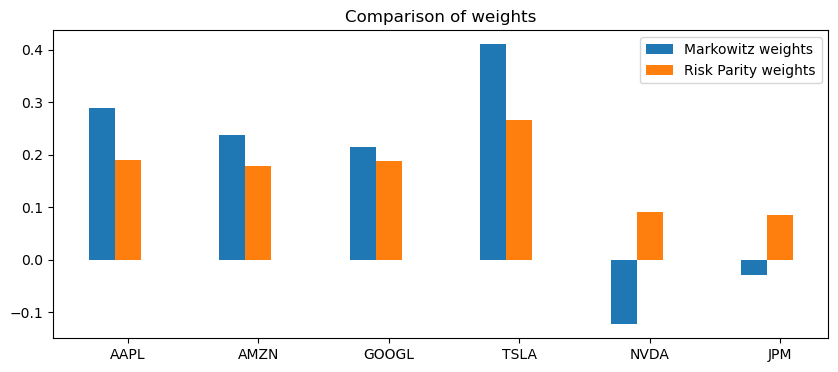

In [23]:
plot_weights(wBarM,resRP.x,'Markowitz weights','Risk Parity weights', 'Comparison of weights')

# Summary of the three approaches:
# 1. **Markowitz**: This approach optimizes portfolio weights based on expected returns (muBar) and the covariance matrix (SigmaBar).
#    It can lead to extreme allocations if the expected returns are not accurate.
#    It assumes that the input expected returns are reliable and does not account for uncertainty in these estimates.
#
# 2. **Black-Litterman**: This approach improves the Markowitz model by combining market equilibrium returns (CAPM) with investor views (Q).
#    The posterior returns (muBarPost) are a weighted combination of equilibrium returns (Pi) and views, balanced by the level of confidence (Omega).
#    It produces more stable and diversified allocations, as it adjusts the expected returns based on both market data and investor opinions.
#
# 3. **Risk Parity**: This approach does not rely on expected returns at all. Instead, it focuses on equalizing the risk contribution of each asset.
#    The goal is to create a portfolio where the risk is balanced, preventing any single asset from dominating the portfolio risk.
#    It is a conservative strategy that often leads to better diversification, especially when the estimates of expected returns are uncertain.

In [24]:
# Extract the vector of individual asset volatilities (Sigma_k)
# Sigma_k represents the standard deviation (volatility) of each asset, calculated as the square root of the diagonal elements of SigmaBar.
Sigma_k = np.sqrt(np.diag(SigmaBar)).reshape(-1, 1)

# Ensure Marginal Risk Contributions are a column vector
MargRisks = MargRisks.reshape(-1, 1)

# Compare Sigma_k (individual volatilities) with Marginal Risk Contributions
comparison = np.concatenate((Sigma_k, MargRisks), axis=1)
print("Comparison of Sigma_k (Volatilities) and Marginal Risk Contributions:")
print(comparison)

# Compare Sigma_k (individual volatilities) with Marginal Risk Contributions
# The comparison between Sigma_k and Marginal Risks helps us understand the impact of diversification:
# - Sigma_k shows the volatility of each asset in isolation, without considering correlations with other assets.
# - Marginal Risks (MR) represent the risk each asset contributes to the total portfolio risk, accounting for both volatility and correlations.
# - If MR > Sigma_k, it suggests that the asset contributes more to risk due to high correlation with other assets.
# - If MR < Sigma_k, it suggests that the asset benefits from diversification, reducing its risk contribution to the portfolio.
# This comparison helps assess whether the portfolio is well-diversified and if the risk contributions are balanced.

Comparison of Sigma_k (Volatilities) and Marginal Risk Contributions:
[[0.30840413 0.25226613]
 [0.34055622 0.262312  ]
 [0.31131124 0.25190099]
 [0.30622955 0.20195365]
 [0.51869755 0.39543054]
 [0.64463645 0.41912307]]


In [25]:
# Analysis of Sigma_k (Volatilities) and Marginal Risk Contributions:
# - In general, Marginal Risk Contributions (MR) are slightly lower than individual volatilities (Sigma_k),
#   indicating effective diversification in the portfolio.
